In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from patsy import dmatrices
import statsmodels.formula.api as smf

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [2]:
df_path = '/Users/jscs/Downloads/Wolverine.xlsx'
df = pd.read_excel(df_path)
print('tamaño de los datos: ', df.shape)
print('columnas de los datos: ', df.columns)
df.head()

tamaño de los datos:  (11200, 5)
columnas de los datos:  Index(['depto', 'municipio', 'año', 'D', 'outcome'], dtype='object')


,depto,municipio,año,D,outcome
0,1,1,1,0,2.748482
1,1,1,2,0,2.285876
2,1,1,3,0,1.847981
3,1,1,4,0,2.036179
4,1,1,5,0,2.058615


Datos sobre el nivel de la tasa de crímenes contra la propiedad en los municipios de Colombia por 100 mil habitantes. Se trata de datos sobre 32 Departamentos, que incluyen 35 municipios por departamento seguidos por 10 años. Colombia decidió pasar una ley para aprovechar el adamantio a mitad del año seis (es decir, a partir del año 7, los 19 departamento que cumplieron con la medida nacional son tratados). Sin embargo 13 departamentos se opusieron y decidieron no implementar la medida. La base de datos incluye las siguientes variables:

    a) Depto: Departamento; 
    b) municipio (Municipio);
    c) Año: el año, de uno a diez; 
    d) D, igual a uno si el departamento es entre los 19 que adoptaron la medida; e) outcome: la tasa de crímenes contra la propiedad en los municipios de Colombia por 100 mil habitantes. 

In [3]:
# useful conceptual notebook for DiffDiff, not too useful for this work
# https://nbviewer.jupyter.org/github/matheusfacure/python-causality-handbook/blob/master/causal-inference-for-the-brave-and-true/14-Difference-in-Difference.ipynb

In [4]:
# bur if you're R lover take a look:
# https://evalf20.classes.andrewheiss.com/example/diff-in-diff/#comparison-of-results

# Análisis Exploratorio

In [5]:
print('departamentos:',df['depto'].unique())

departamentos: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]


<AxesSubplot:title={'center':'Datos por Departamento'}>

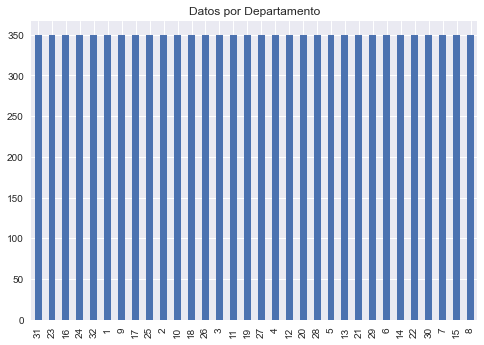

In [6]:
df['depto'].value_counts().plot(kind='bar',title='Datos por Departamento')

In [7]:
print('Número de municipios:', len(df['municipio'].unique()))

Número de municipios: 1120


In [8]:
df['municipio'].value_counts()

1119    10
762     10
714     10
722     10
730     10
        ..
325     10
317     10
309     10
301     10
8       10
Name: municipio, Length: 1120, dtype: int64

In [9]:
print('Número de años:',df['año'].unique())

Número de años: [ 1  2  3  4  5  6  7  8  9 10]


<AxesSubplot:title={'center':'Datos por año'}>

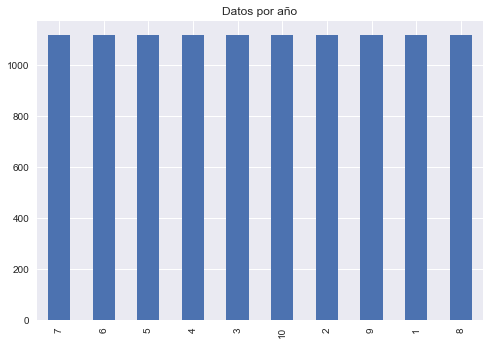

In [10]:
df['año'].value_counts().plot(kind='bar',title='Datos por año')

In [11]:
print('Unidades tratadas:',df['D'].sum())

Unidades tratadas: 6650


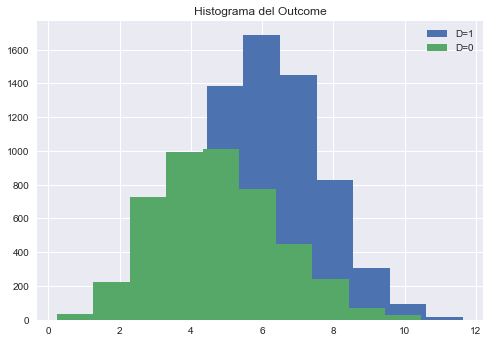

In [12]:
df_D_1 = df[df['D']==1]
df_D_1['outcome'].hist(label='D=1')
df_D_0 = df[df['D']==0]
df_D_0['outcome'].hist(label='D=0').set_title('Histograma del Outcome')
plt.legend()

# Tendencias paralelas

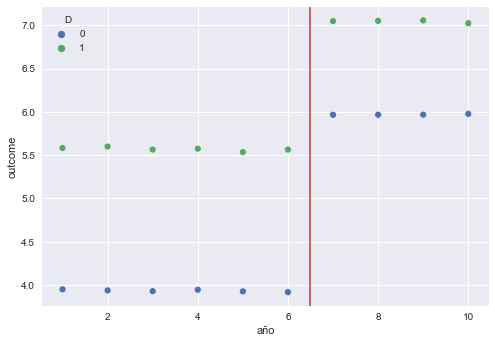

In [13]:
df_mean_depto = df.groupby(['depto','año']).mean()
df_mean_depto = df_mean_depto.reset_index()
df_agregados = df_mean_depto.groupby(['D','año']).mean()
df_agregados = df_agregados.reset_index()
df_agregados = df_agregados[['D', 'año','outcome']]

sns.scatterplot(x="año", y="outcome", hue="D", data=df_agregados, )
plt.axvline(6.5,color="C2")

# Resultados 1

In [14]:
df['ley_adamantio'] = df['año'].map(lambda x: 1 if x > 6.5 else 0)

In [15]:
# reg1: OLS with dummy treatment (D), dummy expost, dummy interaction, 
# Una regresión OLS con la dummy de tratamiento, una dummy por el ex post,
# y la interacción, con errores estándares robustos; 
smf.ols('outcome ~ D*ley_adamantio + D + ley_adamantio',data=df,).fit(cov_type='HC1').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     2364.
Date:                Tue, 08 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:29:20   Log-Likelihood:                -19310.
No. Observations:               11200   AIC:                         3.863e+04
Df Residuals:                   11196   BIC:                         3.866e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.9331      0.025    155.510      0.000       3.884       3.983
D                   1.6372      0.032     50.565      0.000       1.574       1.701
ley_adamantio       2.0365      0.042     48.122      0.000       1.954       2.119
D:ley_adamantio    -0.5611      0.055    -10.274      0.000      -0.668      -0.454
==============================================================================
Omnibus:                       32.658   Durbin-Watson:                   0.230
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.198
Skew:                           0.118   Prob(JB):                     1.02e-07
Kurtosis:                       2.885   Cond. No.                         7.10
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [16]:
smf.ols('outcome ~ D*ley_adamantio + D + ley_adamantio',data=df,).fit().get_robustcov_results(
                                    cov_type='HC1',).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     2364.
Date:                Tue, 08 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:29:20   Log-Likelihood:                -19310.
No. Observations:               11200   AIC:                         3.863e+04
Df Residuals:                   11196   BIC:                         3.866e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.9331      0.025    155.510      0.000       3.884       3.983
D                   1.6372      0.032     50.565      0.000       1.574       1.701
ley_adamantio       2.0365      0.042     48.122      0.000       1.954       2.119
D:ley_adamantio    -0.5611      0.055    -10.274      0.000      -0.668      -0.454
==============================================================================
Omnibus:                       32.658   Durbin-Watson:                   0.230
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.198
Skew:                           0.118   Prob(JB):                     1.02e-07
Kurtosis:                       2.885   Cond. No.                         7.10
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [17]:
import econtools
import econtools.metrics as mt

# more packages: 
#     https://github.com/colin-fraser/regressions.py
#     http://www.danielmsullivan.com/econtools/metrics.html#metrics
#     https://bashtage.github.io/linearmodels/

# nice thread about python and econometrics packages
# https://twitter.com/VC31415/status/1298267993474916360

df['DiD'] = df['D']*df['ley_adamantio']
result = mt.reg(df,'outcome',['D', 'DiD','ley_adamantio'],addcons=True)
print(result.summary)  

                  coeff        se           t           p>t    CI_low  \
D              1.637189  0.033708   48.569331  0.000000e+00  1.571114   
DiD           -0.561091  0.053297  -10.527530  8.512516e-26 -0.665563   
ley_adamantio  2.036487  0.041068   49.587624  0.000000e+00  1.955986   
_cons          3.933119  0.025974  151.425404  0.000000e+00  3.882206   

                CI_high  
D              1.703263  
DiD           -0.456618  
ley_adamantio  2.116989  
_cons          3.984033  


In [18]:
# Una regresión OLS con efectos fijos por departamento, efectos fijos por año, 
# y Tratamiento X expost, con errores estándares robustos; 
# reg2: OLS with dummy treatment (D), dummy expost, dummy interaction, 
#       fixed effect dpto, tiempo
# this post save me
# http://aeturrell.com/2018/02/20/econometrics-in-python-partII-fixed-effects/ 
# other useful info for fixed effect
# https://stackoverflow.com/questions/24195432/fixed-effect-in-pandas-or-statsmodels
smf.ols('outcome ~  D*ley_adamantio +C(año)+C(depto)',data=df,).fit(
                cov_type='HC1').summary()

/Users/jscs/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 43, but rank is 41
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     550.5
Date:                Tue, 08 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:29:20   Log-Likelihood:                -15983.
No. Observations:               11200   AIC:                         3.205e+04
Df Residuals:                   11158   BIC:                         3.236e+04
Df Model:                          41                                         
Covariance Type:                  HC1                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.3839      0.061     55.381      0.000       3.264       3.504
C(año)[T.2]         0.0051      0.032      0.159      0.873      -0.057       0.068
C(año)[T.3]        -0.0194      0.034     -0.572      0.567      -0.086       0.047
C(año)[T.4]        -0.0059      0.036     -0.166      0.868      -0.076       0.064
C(año)[T.5]        -0.0373      0.037     -0.998      0.318      -0.111       0.036
C(año)[T.6]        -0.0240      0.038     -0.624      0.533      -0.099       0.051
C(año)[T.7]         0.4055      0.029     13.843      0.000       0.348       0.463
C(año)[T.8]         0.4071      0.030     13.716      0.000       0.349       0.465
C(año)[T.9]         0.4106      0.030     13.529      0.000       0.351       0.470
C(año)[T.10]        0.3952      0.031     12.953      0.000       0.335       0.455
C(depto)[T.2]      -1.3090      0.058    -22.676      0.000      -1.422      -1.196
C(depto)[T.3]       0.0031      0.043      0.072      0.943      -0.082       0.088
C(depto)[T.4]       1.9640      0.054     36.691      0.000       1.859       2.069
C(depto)[T.5]       0.2050      0.085      2.406      0.016       0.038       0.372
C(depto)[T.6]      -0.0353      0.077     -0.457      0.648      -0.187       0.116
C(depto)[T.7]       0.1379      0.052      2.673      0.008       0.037       0.239
C(depto)[T.8]       1.1945      0.080     14.855      0.000       1.037       1.352
C(depto)[T.9]       1.0214      0.047     21.652      0.000       0.929       1.114
C(depto)[T.10]      0.6374      0.078      8.152      0.000       0.484       0.791
C(depto)[T.11]      1.3836      0.079     17.440      0.000       1.228       1.539
C(depto)[T.12]     -1.3993      0.053    -26.221      0.000      -1.504      -1.295
C(depto)[T.13]      2.2481      0.082     27.315      0.000       2.087       2.409
C(depto)[T.14]     -1.0843      0.060    -18.132      0.000      -1.201      -0.967
C(depto)[T.15]      0.6578      0.049     13.356      0.000       0.561       0.754
C(depto)[T.16]      0.6333      0.050     12.748      0.000       0.536       0.731
C(depto)[T.17]      0.1468      0.054      2.706      0.007       0.040       0.253
C(depto)[T.18]      0.8252      0.053     15.661      0.000       0.722       0.928
C(depto)[T.19]     -0.2091      0.080     -2.611      0.009      -0.366      -0.052
C(depto)[T.20]     -0.8697      0.049    -17.582      0.000      -0.967      -0.773
C(depto)[T.21]     -0.1090      0.084     -1.299      0.194      -0.273       0.055
C(depto)[T.22]     -0.7458      0.050    -14.897      0.000      -0.844      -0.648
C(depto)[T.23]     -0.0549      0.081     -0.675      0.500      -0.214       0.105
C(depto)[T.24]     -0.4604      0.077     -6.010      0.000      -0.611      -0.310
C(depto)[T.25]      0.6238      0.054     11.601      0.000

In [19]:
# reg3:  Una regresión de efectos fijos, con efectos fijos por año, 
#        y Tratamiento X expost, con errores estándares agrupados por municipios;
# cluster in python
# https://stackoverflow.com/questions/54349525/clustered-standard-errors-in-statsmodels-with-categorical-variables-python

# algo falla acá?
smf.ols('outcome ~ ley_adamantio + D*ley_adamantio +C(año)',data=df,).fit(
               cov_type='cluster', cov_kwds={'groups': df['municipio']}).summary()

/Users/jscs/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 1
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                 4.948e-15
Date:                Tue, 08 Dec 2020   Prob (F-statistic):               1.00
Time:                        01:29:21   Log-Likelihood:                -19310.
No. Observations:               11200   AIC:                         3.864e+04
Df Residuals:                   11188   BIC:                         3.873e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.9421   6.19e+04   6.37e-05      1.000   -1.21e+05    1.21e+05
C(año)[T.2]         0.0064   1.95e+04    3.3e-07      1.000   -3.82e+04    3.82e+04
C(año)[T.3]         0.0051   3.56e+05   1.44e-08      1.000   -6.98e+05    6.98e+05
C(año)[T.4]        -0.0035   3.24e+04  -1.08e-07      1.000   -6.36e+04    6.36e+04
C(año)[T.5]        -0.0334   6.03e+04  -5.54e-07      1.000   -1.18e+05    1.18e+05
C(año)[T.6]        -0.0273   5.25e+04  -5.21e-07      1.000   -1.03e+05    1.03e+05
C(año)[T.7]      2.895e+12   4.42e+19   6.55e-08      1.000   -8.67e+19    8.67e+19
C(año)[T.8]      2.895e+12   4.13e+19   7.01e-08      1.000    -8.1e+19     8.1e+19
C(año)[T.9]      2.895e+12   4.33e+19   6.69e-08      1.000   -8.48e+19    8.48e+19
C(año)[T.10]     2.895e+12   3.71e+19    7.8e-08      1.000   -7.27e+19    7.27e+19
ley_adamantio   -2.895e+12   3.71e+19   -7.8e-08      1.000   -7.27e+19    7.27e+19
D                   1.6369   3852.274      0.000      1.000   -7548.682    7551.955
D:ley_adamantio    -0.5613   3485.964     -0.000      1.000   -6832.924    6831.802
==============================================================================
Omnibus:                       33.073   Durbin-Watson:                   0.230
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.614
Skew:                           0.119   Prob(JB):                     8.28e-08
Kurtosis:                       2.885   Cond. No.                     9.71e+14
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The smallest eigenvalue is 2.14e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [20]:
# https://stackoverflow.com/questions/44305456/why-am-i-getting-linalgerror-singular-matrix-from-grangercausalitytests
y = 'outcome'
X = ['DiD',]
fe_var = 'año'
cluster_var = 'municipio'
#weights_var = 'sample_wt'

results = mt.reg(
    df,                     # DataFrame
    y,                      # Dependent var (string)
    X,                      # Independent var(s) (string or list of strings)
    fe_name=fe_var,         # Fixed-effects/absorb var (string)
    cluster=cluster_var,    # Cluster var (string)
    #awt_name=weights_var    # Sample weights
    addcons=True)
    
results

Dependent variable:	outcome
N:			11200
R-squared:		0.2661
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  municipio
  No. of clusters:	  1120
Fixed effects by:	año
  No. of FE:		  10
    coeff    se      t   p>t CI_low CI_high
DiD 1.076 0.085 12.708 0.000  0.910   1.242

# Resultados 2: BDM

In [21]:
# 1. efecto fijo agrupado a nivel de departamento
smf.ols('outcome ~  D*ley_adamantio +C(año)',data=df).fit(
        cov_type='cluster', cov_kwds={'groups': df['depto']}).summary()

/Users/jscs/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/jscs/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                 1.675e-15
Date:                Tue, 08 Dec 2020   Prob (F-statistic):               1.00
Time:                        01:29:21   Log-Likelihood:                -19310.
No. Observations:               11200   AIC:                         3.864e+04
Df Residuals:                   11188   BIC:                         3.873e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.9426   7.32e+04   5.39e-05      1.000   -1.43e+05    1.43e+05
C(año)[T.2]         0.0056   1.21e+04   4.65e-07      1.000   -2.37e+04    2.37e+04
C(año)[T.3]         0.0047   5.86e+05   8.02e-09      1.000   -1.15e+06    1.15e+06
C(año)[T.4]        -0.0046   2.29e+04  -2.02e-07      1.000   -4.49e+04    4.49e+04
C(año)[T.5]        -0.0337   8.42e+04     -4e-07      1.000   -1.65e+05    1.65e+05
C(año)[T.6]        -0.0286        nan        nan        nan         nan         nan
C(año)[T.7]      2.895e+12    8.2e+19   3.53e-08      1.000   -1.61e+20    1.61e+20
C(año)[T.8]      2.895e+12   7.32e+19   3.95e-08      1.000   -1.44e+20    1.44e+20
C(año)[T.9]      2.895e+12   6.33e+19   4.58e-08      1.000   -1.24e+20    1.24e+20
C(año)[T.10]     2.895e+12   3.57e+19    8.1e-08      1.000      -7e+19       7e+19
D                   1.6367   1.06e+04      0.000      1.000   -2.08e+04    2.08e+04
ley_adamantio   -2.895e+12   3.57e+19   -8.1e-08      1.000      -7e+19       7e+19
D:ley_adamantio    -0.5614   4181.371     -0.000      1.000   -8195.897    8194.774
==============================================================================
Omnibus:                       33.256   Durbin-Watson:                   0.230
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.796
Skew:                           0.119   Prob(JB):                     7.56e-08
Kurtosis:                       2.885   Cond. No.                     9.71e+14
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The smallest eigenvalue is 2.14e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [22]:
# https://stackoverflow.com/questions/44305456/why-am-i-getting-linalgerror-singular-matrix-from-grangercausalitytests
y = 'outcome'
X = ['DiD',]
fe_var = 'año'
cluster_var = 'depto'
#weights_var = 'sample_wt'

results = mt.reg(
    df,                     # DataFrame
    y,                      # Dependent var (string)
    X,                      # Independent var(s) (string or list of strings)
    fe_name=fe_var,         # Fixed-effects/absorb var (string)
    cluster=cluster_var,    # Cluster var (string)
    #awt_name=weights_var    # Sample weights
    addcons=True)
results

Dependent variable:	outcome
N:			11200
R-squared:		0.2661
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  depto
  No. of clusters:	  32
Fixed effects by:	año
  No. of FE:		  10
    coeff    se     t   p>t CI_low CI_high
DiD 1.076 0.335 3.208 0.003  0.392   1.760

In [23]:
# 2. Block Boots
# https://stackoverflow.com/questions/43151401/bootstrapping-multiple-regression-parameters-in-python
# look https://www.textbook.ds100.org/ch/18/hyp_regression.html
#xtreg outcome DiD i.time, fe vce(boot, strata(state) reps(99))

from sklearn.utils import resample
data = df.copy()
boot = resample(data, replace=True, n_samples=11200, random_state=99)

smf.ols('outcome ~  D*ley_adamantio +C(depto)',data=boot).fit(cov_type='HC1').summary()

/Users/jscs/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 34, but rank is 33
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     647.5
Date:                Tue, 08 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:29:23   Log-Likelihood:                -16106.
No. Observations:               11200   AIC:                         3.228e+04
Df Residuals:                   11166   BIC:                         3.253e+04
Df Model:                          33                                         
Covariance Type:                  HC1                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.3793      0.057     58.932      0.000       3.267       3.492
C(depto)[T.2]      -1.3590      0.061    -22.210      0.000      -1.479      -1.239
C(depto)[T.3]       0.0179      0.044      0.404      0.687      -0.069       0.105
C(depto)[T.4]       1.8775      0.054     34.847      0.000       1.772       1.983
C(depto)[T.5]       0.1837      0.086      2.139      0.032       0.015       0.352
C(depto)[T.6]      -0.0658      0.076     -0.869      0.385      -0.214       0.083
C(depto)[T.7]       0.1591      0.054      2.948      0.003       0.053       0.265
C(depto)[T.8]       1.1235      0.081     13.821      0.000       0.964       1.283
C(depto)[T.9]       1.0209      0.047     21.697      0.000       0.929       1.113
C(depto)[T.10]      0.5943      0.079      7.525      0.000       0.440       0.749
C(depto)[T.11]      1.3924      0.074     18.936      0.000       1.248       1.536
C(depto)[T.12]     -1.4285      0.054    -26.584      0.000      -1.534      -1.323
C(depto)[T.13]      2.1935      0.078     28.232      0.000       2.041       2.346
C(depto)[T.14]     -1.1092      0.062    -17.790      0.000      -1.231      -0.987
C(depto)[T.15]      0.6707      0.048     13.989      0.000       0.577       0.765
C(depto)[T.16]      0.6243      0.052     12.016      0.000       0.522       0.726
C(depto)[T.17]      0.1936      0.053      3.628      0.000       0.089       0.298
C(depto)[T.18]      0.8218      0.052     15.909      0.000       0.721       0.923
C(depto)[T.19]     -0.1161      0.079     -1.466      0.143      -0.271       0.039
C(depto)[T.20]     -0.9173      0.050    -18.454      0.000      -1.015      -0.820
C(depto)[T.21]     -0.0844      0.082     -1.029      0.304      -0.245       0.076
C(depto)[T.22]     -0.7089      0.049    -14.374      0.000      -0.806      -0.612
C(depto)[T.23]     -0.0480      0.082     -0.583      0.560      -0.210       0.113
C(depto)[T.24]     -0.4038      0.079     -5.119      0.000      -0.558      -0.249
C(depto)[T.25]      0.5838      0.057     10.190      0.000       0.471       0.696
C(depto)[T.26]     -0.4464      0.042    -10.509      0.000      -0.530      -0.363
C(depto)[T.27]      0.6583      0.047     14.124      0.000       0.567       0.750
C(depto)[T.28]      0.0572      0.068      0.846      0.398      -0.075       0.190
C(depto)[T.29]      2.4556      0.075     32.758      0.000       2.309       2.603
C(depto)[T.30]      1.0397      0.063     16.460      0.000       0.916       1.163
C(depto)[T.31]     -0.4719      0.057     -8.283      0.000      -0.584      -0.360
C(depto)[T.32]      0.8522      0.052     16.373      0.000       0.750       0.954
D                   2.0785      0.056     37.010      0.000       1.968       2.189
ley_adamantio       2.0339      0.032     63.831      0.000

In [24]:
# 3. 
df_cercano_a_fecha_de_ley = df[(df['año']==6)|(df['año']==7)]
smf.ols('outcome ~  D*ley_adamantio + ley_adamantio +C(depto)',data=df_cercano_a_fecha_de_ley).fit(
                cov_type='HC1').summary()

/Users/jscs/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 34, but rank is 33
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     120.9
Date:                Tue, 08 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:29:23   Log-Likelihood:                -3355.1
No. Observations:                2240   AIC:                             6778.
Df Residuals:                    2206   BIC:                             6973.
Df Model:                          33                                         
Covariance Type:                  HC1                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.2810      0.148     22.132      0.000       2.990       3.572
C(depto)[T.2]      -1.2757      0.139     -9.202      0.000      -1.547      -1.004
C(depto)[T.3]       0.0411      0.094      0.438      0.661      -0.143       0.225
C(depto)[T.4]       1.8771      0.132     14.186      0.000       1.618       2.136
C(depto)[T.5]       0.2926      0.207      1.417      0.157      -0.112       0.697
C(depto)[T.6]       0.0055      0.183      0.030      0.976      -0.354       0.365
C(depto)[T.7]       0.1508      0.121      1.249      0.212      -0.086       0.387
C(depto)[T.8]       1.3034      0.206      6.336      0.000       0.900       1.707
C(depto)[T.9]       0.9907      0.107      9.265      0.000       0.781       1.200
C(depto)[T.10]      0.5526      0.193      2.866      0.004       0.175       0.931
C(depto)[T.11]      1.4014      0.193      7.278      0.000       1.024       1.779
C(depto)[T.12]     -1.5290      0.133    -11.468      0.000      -1.790      -1.268
C(depto)[T.13]      2.3693      0.212     11.196      0.000       1.955       2.784
C(depto)[T.14]     -1.0295      0.142     -7.269      0.000      -1.307      -0.752
C(depto)[T.15]      0.6512      0.119      5.482      0.000       0.418       0.884
C(depto)[T.16]      0.7025      0.128      5.486      0.000       0.451       0.953
C(depto)[T.17]      0.0868      0.128      0.680      0.497      -0.164       0.337
C(depto)[T.18]      0.9286      0.127      7.329      0.000       0.680       1.177
C(depto)[T.19]     -0.1613      0.187     -0.864      0.388      -0.527       0.205
C(depto)[T.20]     -0.8254      0.124     -6.682      0.000      -1.068      -0.583
C(depto)[T.21]     -0.0703      0.204     -0.344      0.731      -0.471       0.330
C(depto)[T.22]     -0.8082      0.124     -6.528      0.000      -1.051      -0.566
C(depto)[T.23]      0.0222      0.200      0.111      0.912      -0.370       0.415
C(depto)[T.24]     -0.3012      0.188     -1.602      0.109      -0.670       0.067
C(depto)[T.25]      0.5381      0.125      4.310      0.000       0.293       0.783
C(depto)[T.26]     -0.2203      0.102     -2.158      0.031      -0.420      -0.020
C(depto)[T.27]      0.6211      0.112      5.557      0.000       0.402       0.840
C(depto)[T.28]      0.2261      0.165      1.371      0.170      -0.097       0.549
C(depto)[T.29]      2.6111      0.185     14.093      0.000       2.248       2.974
C(depto)[T.30]      1.0017      0.159      6.293      0.000       0.690       1.314
C(depto)[T.31]     -0.6770      0.137     -4.948      0.000      -0.945      -0.409
C(depto)[T.32]      0.9450      0.133      7.080      0.000       0.683       1.207
D                   2.1695      0.146     14.825      0.000       1.883       2.456
ley_adamantio       2.0512      0.073     28.131      0.000

In [25]:
# https://stackoverflow.com/questions/44305456/why-am-i-getting-linalgerror-singular-matrix-from-grangercausalitytests
y = 'outcome'
X = ['DiD',]
fe_var = 'año'
#weights_var = 'sample_wt'

results = mt.reg(
    df_cercano_a_fecha_de_ley,                     # DataFrame
    y,                      # Dependent var (string)
    X,                      # Independent var(s) (string or list of strings)
    fe_name=fe_var,         # Fixed-effects/absorb var (string)
    #cluster=cluster_var,    # Cluster var (string)
    #awt_name=weights_var    # Sample weights
    addcons=True)
results

Dependent variable:	outcome
N:			2240
R-squared:		0.2724
Estimation method:	OLS
VCE method:		Standard (Homosk.)
Fixed effects by:	año
  No. of FE:		  2
    coeff    se      t   p>t CI_low CI_high
DiD 1.082 0.093 11.620 0.000  0.900   1.265

# Event Study

In [26]:
dummies = pd.get_dummies(df['año'],  prefix='dtime')
dummies = dummies.drop(columns=['dtime_6'])
df_LL = pd.concat([df['D'],dummies],axis=1)

for i in dummies.columns:
    df_LL['LL'+i] = df_LL['D']*df_LL[i]
df_event_study = pd.concat([df,df_LL],axis=1)

In [27]:
df_event_study.columns

Index(['depto', 'municipio', 'año', 'D', 'outcome', 'ley_adamantio', 'DiD',
       'D', 'dtime_1', 'dtime_2', 'dtime_3', 'dtime_4', 'dtime_5', 'dtime_7',
       'dtime_8', 'dtime_9', 'dtime_10', 'LLdtime_1', 'LLdtime_2', 'LLdtime_3',
       'LLdtime_4', 'LLdtime_5', 'LLdtime_7', 'LLdtime_8', 'LLdtime_9',
       'LLdtime_10'],
      dtype='object')

In [28]:
smf.ols('outcome ~  dtime_1 + dtime_2 + dtime_3 + dtime_4 + dtime_5 + dtime_7 + dtime_8 + dtime_9 +dtime_10 + LLdtime_1 + LLdtime_2 + LLdtime_3 +  LLdtime_4 + LLdtime_5 + LLdtime_7 + LLdtime_8 + LLdtime_9 + LLdtime_10 + C(depto)',
        data=df_event_study).fit(
        cov_type='HC1').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     467.7
Date:                Tue, 08 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:29:24   Log-Likelihood:                -15982.
No. Observations:               11200   AIC:                         3.206e+04
Df Residuals:                   11150   BIC:                         3.243e+04
Df Model:                          49                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.3529      0.076     43.977      0.000       3.203       3.502
C(depto)[T.2]      0.7927      0.105      7.568      0.000       0.587       0.998
C(depto)[T.3]      2.1049      0.096     21.873      0.000       1.916       2.294
C(depto)[T.4]      4.0658      0.102     39.807      0.000       3.866       4.266
C(depto)[T.5]      0.2050      0.085      2.406      0.016       0.038       0.372
C(depto)[T.6]     -0.0353      0.077     -0.456      0.648      -0.187       0.116
C(depto)[T.7]      2.2397      0.101     22.192      0.000       2.042       2.437
C(depto)[T.8]      1.1945      0.080     14.850      0.000       1.037       1.352
C(depto)[T.9]      3.1231      0.098     31.718      0.000       2.930       3.316
C(depto)[T.10]     0.6374      0.078      8.151      0.000       0.484       0.791
C(depto)[T.11]     1.3836      0.079     17.437      0.000       1.228       1.539
C(depto)[T.12]     0.7024      0.102      6.857      0.000       0.502       0.903
C(depto)[T.13]     2.2481      0.082     27.309      0.000       2.087       2.409
C(depto)[T.14]     1.0175      0.106      9.603      0.000       0.810       1.225
C(depto)[T.15]     2.7596      0.100     27.691      0.000       2.564       2.955
C(depto)[T.16]     2.7351      0.100     27.354      0.000       2.539       2.931
C(depto)[T.17]     2.2486      0.103     21.906      0.000       2.047       2.450
C(depto)[T.18]     2.9269      0.102     28.797      0.000       2.728       3.126
C(depto)[T.19]    -0.2091      0.080     -2.610      0.009      -0.366      -0.052
C(depto)[T.20]     1.2321      0.100     12.321      0.000       1.036       1.428
C(depto)[T.21]    -0.1090      0.084     -1.299      0.194      -0.274       0.055
C(depto)[T.22]     1.3560      0.100     13.559      0.000       1.160       1.552
C(depto)[T.23]    -0.0549      0.081     -0.675      0.500      -0.214       0.105
C(depto)[T.24]    -0.4604      0.077     -6.008      0.000      -0.611      -0.310
C(depto)[T.25]     2.7256      0.102     26.652      0.000       2.525       2.926
C(depto)[T.26]     1.6688      0.097     17.235      0.000       1.479       1.859
C(depto)[T.27]     2.6697      0.098     27.200      0.000       2.477       2.862
C(depto)[T.28]     0.0699      0.070      1.004      0.315      -0.067       0.206
C(depto)[T.29]     2.4472      0.076     32.203      0.000       2.298       2.596
C(depto)[T.30]     3.0418      0.108     28.095      0.000       2.830       3.254
C(depto)[T.31]     1.5497      0.103     14.987      0.000       1.347       1.752
C(depto)[T.32]     3.0638      0.102     30.116      0.000       2.864       3.263
dtime_1            0.0330      0.062      0.536      0.592      -0.088       0.154
dtime_2            0.0211      0.066      0.322      0.747      -0.107       0.150
dtime_3     

In [29]:
smf.ols('outcome ~  dtime_1 + dtime_2 + dtime_3 + dtime_4 + dtime_5 + dtime_7 + dtime_8 + dtime_9 +dtime_10 + LLdtime_1 + LLdtime_2 + LLdtime_3 +  LLdtime_4 + LLdtime_5 + LLdtime_7 + LLdtime_8 + LLdtime_9 + LLdtime_10 + C(depto)',
        data=df_event_study).fit(
        cov_type='HC1').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     467.7
Date:                Tue, 08 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:29:25   Log-Likelihood:                -15982.
No. Observations:               11200   AIC:                         3.206e+04
Df Residuals:                   11150   BIC:                         3.243e+04
Df Model:                          49                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.3529      0.076     43.977      0.000       3.203       3.502
C(depto)[T.2]      0.7927      0.105      7.568      0.000       0.587       0.998
C(depto)[T.3]      2.1049      0.096     21.873      0.000       1.916       2.294
C(depto)[T.4]      4.0658      0.102     39.807      0.000       3.866       4.266
C(depto)[T.5]      0.2050      0.085      2.406      0.016       0.038       0.372
C(depto)[T.6]     -0.0353      0.077     -0.456      0.648      -0.187       0.116
C(depto)[T.7]      2.2397      0.101     22.192      0.000       2.042       2.437
C(depto)[T.8]      1.1945      0.080     14.850      0.000       1.037       1.352
C(depto)[T.9]      3.1231      0.098     31.718      0.000       2.930       3.316
C(depto)[T.10]     0.6374      0.078      8.151      0.000       0.484       0.791
C(depto)[T.11]     1.3836      0.079     17.437      0.000       1.228       1.539
C(depto)[T.12]     0.7024      0.102      6.857      0.000       0.502       0.903
C(depto)[T.13]     2.2481      0.082     27.309      0.000       2.087       2.409
C(depto)[T.14]     1.0175      0.106      9.603      0.000       0.810       1.225
C(depto)[T.15]     2.7596      0.100     27.691      0.000       2.564       2.955
C(depto)[T.16]     2.7351      0.100     27.354      0.000       2.539       2.931
C(depto)[T.17]     2.2486      0.103     21.906      0.000       2.047       2.450
C(depto)[T.18]     2.9269      0.102     28.797      0.000       2.728       3.126
C(depto)[T.19]    -0.2091      0.080     -2.610      0.009      -0.366      -0.052
C(depto)[T.20]     1.2321      0.100     12.321      0.000       1.036       1.428
C(depto)[T.21]    -0.1090      0.084     -1.299      0.194      -0.274       0.055
C(depto)[T.22]     1.3560      0.100     13.559      0.000       1.160       1.552
C(depto)[T.23]    -0.0549      0.081     -0.675      0.500      -0.214       0.105
C(depto)[T.24]    -0.4604      0.077     -6.008      0.000      -0.611      -0.310
C(depto)[T.25]     2.7256      0.102     26.652      0.000       2.525       2.926
C(depto)[T.26]     1.6688      0.097     17.235      0.000       1.479       1.859
C(depto)[T.27]     2.6697      0.098     27.200      0.000       2.477       2.862
C(depto)[T.28]     0.0699      0.070      1.004      0.315      -0.067       0.206
C(depto)[T.29]     2.4472      0.076     32.203      0.000       2.298       2.596
C(depto)[T.30]     3.0418      0.108     28.095      0.000       2.830       3.254
C(depto)[T.31]     1.5497      0.103     14.987      0.000       1.347       1.752
C(depto)[T.32]     3.0638      0.102     30.116      0.000       2.864       3.263
dtime_1            0.0330      0.062      0.536      0.592      -0.088       0.154
dtime_2            0.0211      0.066      0.322      0.747      -0.107       0.150
dtime_3     

In [30]:
event_study = smf.ols('outcome ~  dtime_1 + dtime_2 + dtime_3 + dtime_4 + dtime_5 + dtime_7 + dtime_8 + dtime_9 +dtime_10 + LLdtime_1 + LLdtime_2 + LLdtime_3 +  LLdtime_4 + LLdtime_5 + LLdtime_7 + LLdtime_8 + LLdtime_9 + LLdtime_10 + C(depto)',
        data=df_event_study).fit(
        cov_type='HC1').summary().tables[1]

In [31]:
# code from
# https://stackoverflow.com/questions/51734180/converting-statsmodels-summary-object-to-pandas-dataframe
results_as_html = event_study.as_html()
results_as_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
results_as_df = results_as_df.reset_index()
results_as_df = results_as_df.rename(columns={"index": "varname","std err":"err"})
results_as_df = results_as_df[41:].reset_index()
coef_df = results_as_df[['varname', 'coef', 'err']]
coef_df

,varname,coef,err
0,LLdtime_1,-0.0151,0.079
1,LLdtime_2,0.0134,0.083
2,LLdtime_3,-0.0121,0.086
3,LLdtime_4,-0.0180,0.089
4,LLdtime_5,-0.0386,0.092
5,LLdtime_7,-0.5667,0.094
6,LLdtime_8,-0.5642,0.094
7,LLdtime_9,-0.5593,0.096
8,LLdtime_10,-0.6011,0.097


<ipython-input-32-9476bbf209af>:8: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


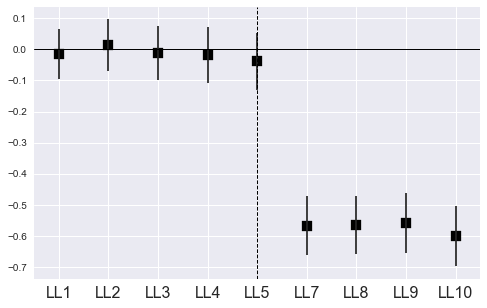

In [32]:
# code from https://zhiyzuo.github.io/Python-Plot-Regression-Coefficient/
fig, ax = plt.subplots(figsize=(8, 5))
coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'], color='black')
ax.axhline(y=0, linestyle='-', color='black', linewidth=1)

var_names = ['LL1','LL2','LL3','LL4','LL5','LL7','LL8','LL9','LL10']
ax.axvline(x=4, linestyle='--', color='black', linewidth=1)

ax.xaxis.set_ticks_position = ax.set_xticklabels(var_names, rotation=0, fontsize=16)

# Placebo

Haga un experimento placebo, clasificando como tratados todos los deptos impares y control los pares e imaginando que el placebo empiece a regir desde el periodo 4

In [33]:
df['D_placebo'] = df['depto'].map(lambda x: 1 if x%2 == 1 else 0)
df['ley_adamantio_placebo'] = df['año'].map(lambda x: 1 if x >= 4 else 0)
df['placebo_DiD'] = df['ley_adamantio_placebo']*df['D_placebo'] 

In [34]:
smf.ols('outcome ~  D_placebo*ley_adamantio_placebo +C(año)',data=df).fit(
                cov_type='cluster', cov_kwds={'groups': df['depto']}).summary()

/Users/jscs/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/jscs/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                -1.785e-15
Date:                Tue, 08 Dec 2020   Prob (F-statistic):               1.00
Time:                        01:29:27   Log-Likelihood:                -20646.
No. Observations:               11200   AIC:                         4.132e+04
Df Residuals:                   11188   BIC:                         4.140e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           4.8549        nan        nan        nan         nan         nan
C(año)[T.2]                         0.0437        nan        nan        nan         nan         nan
C(año)[T.3]                         0.0341        nan        nan        nan         nan         nan
C(año)[T.4]                       6.12e+12   2.46e+19   2.49e-07      1.000   -4.81e+19    4.81e+19
C(año)[T.5]                       6.12e+12        nan        nan        nan         nan         nan
C(año)[T.6]                       6.12e+12        nan        nan        nan         nan         nan
C(año)[T.7]                       6.12e+12   8.97e+19   6.82e-08      1.000   -1.76e+20    1.76e+20
C(año)[T.8]                       6.12e+12        nan        nan        nan         nan         nan
C(año)[T.9]                       6.12e+12        nan        nan        nan         nan         nan
C(año)[T.10]                      6.12e+12   5.98e+19   1.02e-07      1.000   -1.17e+20    1.17e+20
D_placebo                           0.1033        nan        nan        nan         nan         nan
ley_adamantio_placebo            -6.12e+12        nan        nan        nan         nan         nan
D_placebo:ley_adamantio_placebo     0.0370        nan        nan        nan         nan         nan
==============================================================================
Omnibus:                       97.399   Durbin-Watson:                   0.188
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.697
Skew:                           0.028   Prob(JB):                     8.94e-15
Kurtosis:                       2.632   Cond. No.                     9.91e+14
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The smallest eigenvalue is 2.44e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [35]:
y = 'outcome'
X = ['placebo_DiD',]
fe_var = 'año'
cluster_var = 'depto'

results = mt.reg(
    df,                     # DataFrame
    y,                      # Dependent var (string)
    X,                      # Independent var(s) (string or list of strings)
    #fe_name=fe_var,         # Fixed-effects/absorb var (string)
    cluster=cluster_var,    # Cluster var (string)
    addcons=True)
results

Dependent variable:	outcome
N:			11200
R-squared:		0.0226
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  depto
  No. of clusters:	  32
            coeff    se      t   p>t CI_low CI_high
placebo_DiD 0.550 0.309  1.780 0.085 -0.080   1.180
_cons       5.394 0.246 21.922 0.000  4.892   5.896

In [36]:
y = 'outcome'
X = ['placebo_DiD',]
fe_var = 'año'
cluster_var = 'depto'

results = mt.reg(
    df,                     # DataFrame
    y,                      # Dependent var (string)
    X,                      # Independent var(s) (string or list of strings)
    fe_name=fe_var,         # Fixed-effects/absorb var (string)
    cluster=cluster_var,    # Cluster var (string)
    addcons=True)
results

Dependent variable:	outcome
N:			11200
R-squared:		0.2304
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  depto
  No. of clusters:	  32
Fixed effects by:	año
  No. of FE:		  10
            coeff    se     t   p>t CI_low CI_high
placebo_DiD 0.138 0.400 0.345 0.732 -0.678   0.954

In [37]:
y = 'outcome'
X = ['placebo_DiD',]
fe_var = 'año'
cluster_var = 'depto'

results = mt.reg(
    df,                     # DataFrame
    y,                      # Dependent var (string)
    X,                      # Independent var(s) (string or list of strings)
    #fe_name=fe_var,         # Fixed-effects/absorb var (string)
    cluster=cluster_var,    # Cluster var (string)
    addcons=True)
results

Dependent variable:	outcome
N:			11200
R-squared:		0.0226
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  depto
  No. of clusters:	  32
            coeff    se      t   p>t CI_low CI_high
placebo_DiD 0.550 0.309  1.780 0.085 -0.080   1.180
_cons       5.394 0.246 21.922 0.000  4.892   5.896